<a href="https://colab.research.google.com/github/vidurp/notebooks/blob/main/YOLO_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#YOLO object detection

## Dependencies

In [1]:
# Download the PASCAL VOC 2005 dataset
!wget http://host.robots.ox.ac.uk/pascal/VOC/download/voc2005_1.tar.gz

--2025-02-23 21:13:09--  http://host.robots.ox.ac.uk/pascal/VOC/download/voc2005_1.tar.gz
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 487614356 (465M) [application/x-gzip]
Saving to: ‘voc2005_1.tar.gz’

voc2005_1.tar.gz    100%[===================>] 465.02M  18.9MB/s    in 28s     

2025-02-23 21:13:38 (16.3 MB/s) - ‘voc2005_1.tar.gz’ saved [487614356/487614356]



In [2]:
# Helpers to Create YOLO Friendly Dataser from PASCAL VOC 2005
!wget https://raw.githubusercontent.com/vidurp/yolo/refs/heads/main/yolodatasetutils.py

--2025-02-23 21:13:42--  https://raw.githubusercontent.com/vidurp/yolo/refs/heads/main/yolodatasetutils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7517 (7.3K) [text/plain]
Saving to: ‘yolodatasetutils.py’

yolodatasetutils.py 100%[===================>]   7.34K  --.-KB/s    in 0s      

2025-02-23 21:13:42 (75.5 MB/s) - ‘yolodatasetutils.py’ saved [7517/7517]



In [3]:
# Helper to parse PASCAL VOC2005 dataset to extract a dictionary in JSON format
!wget https://raw.githubusercontent.com/vidurp/generic/refs/heads/main/pascalvoc.py

--2025-02-23 21:13:44--  https://raw.githubusercontent.com/vidurp/generic/refs/heads/main/pascalvoc.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4597 (4.5K) [text/plain]
Saving to: ‘pascalvoc.py’

pascalvoc.py        100%[===================>]   4.49K  --.-KB/s    in 0s      

2025-02-23 21:13:44 (60.9 MB/s) - ‘pascalvoc.py’ saved [4597/4597]



In [4]:
# Tensorflow utils
!wget https://raw.githubusercontent.com/vidurp/generic/refs/heads/main/tfhelpers.py

--2025-02-23 21:13:47--  https://raw.githubusercontent.com/vidurp/generic/refs/heads/main/tfhelpers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5709 (5.6K) [text/plain]
Saving to: ‘tfhelpers.py’

tfhelpers.py        100%[===================>]   5.58K  --.-KB/s    in 0s      

2025-02-23 21:13:47 (49.2 MB/s) - ‘tfhelpers.py’ saved [5709/5709]



In [5]:
# uncompress dataset
import tfhelpers
import numpy as np

In [6]:
tfhelpers.UnZipFiles('/content/voc2005_1.tar.gz')

## Create Training DataSet

In [7]:
from pascalvoc import CreateJSONFromPascalDataSet
CreateJSONFromPascalDataSet('/content/VOC2005_1','pascalvoc2005_train.json')

In [8]:
from yolodatasetutils import CreateYOLODataSet
imgtensor, truthlabeltensor = CreateYOLODataSet('pascalvoc2005_train.json' )

In [9]:
imgtensor[0].shape, truthlabeltensor[0].shape,len(imgtensor),len(truthlabeltensor)

((224, 224, 3), (7, 7, 17), 1373, 1373)

In [10]:
truthlabels_tf = [ np.reshape(labeltensor, 833) for labeltensor in truthlabeltensor]

In [ ]:
truthlabels_tf[0].shape

(833,)

In [11]:
ClassLabels = ['carSide', 'person', 'bike', 'car', 'motorbikes', 'motorbikeSide', 'carRear']

In [12]:
import tensorflow as tf

In [13]:
TrainSet = tf.data.Dataset.from_tensor_slices((imgtensor,truthlabels_tf))

In [14]:
TrainSet

<_TensorSliceDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(833,), dtype=tf.float64, name=None))>

In [15]:
TrainSet = TrainSet.batch(1)

## Sample Training DataSet For Accuracy

In [ ]:
from yolodatasetutils import YOLOViewPredImage

In [ ]:
import random

In [ ]:
for img,label in TrainSet.skip(random.randint(0,len(TrainSet))).take(1):
    print(img.shape)

(1, 224, 224, 3)


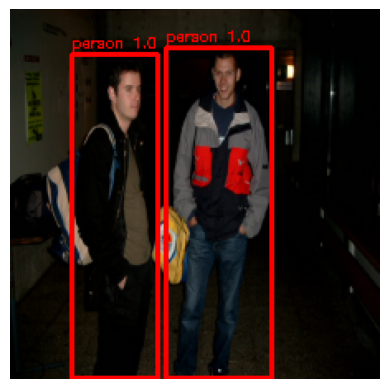

In [ ]:
for img,label in TrainSet.skip(random.randint(0,len(TrainSet))).take(1):
    YOLOViewPredImage( tf.squeeze(img), label, ClassLabels )

## Build a YOLO Like CNN Model

In [16]:
import tensorflow as tf

In [17]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224,224,3)),
    tf.keras.layers.Conv2D( 64, 7, strides=(2,2), activation=tf.keras.activations.relu ),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),

    tf.keras.layers.Conv2D( 192, 3, strides=(1,1), activation=tf.keras.activations.relu ),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),

    tf.keras.layers.Conv2D( 512, 1, strides=(1,1), activation=tf.keras.activations.relu ),
    tf.keras.layers.Conv2D( 1024, 3, strides=(1,1), activation=tf.keras.activations.relu ),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(7*7*(5*2 + 7), activation=tf.keras.activations.softmax ),
    tf.keras.layers.Dense(7*7*(5*2 + 7), activation=tf.keras.activations.softmax )
])

In [18]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 109, 109, 64)        │           9,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 52, 52, 192)         │         110,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 26, 26, 192)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 26, 26, 512)         │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 1024)        │       4,719,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 1024)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 147456)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 833)                 │     122,831,681 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 833)                 │         694,722 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 128,465,091 (490.06 MB)

 Trainable params: 128,465,091 (490.06 MB)

 Non-trainable params: 0 (0.00 B)

### YOLO Loss Function

In [19]:
# Add a tf.function decorator, allows for graph execution
@tf.function
def CalcIOU( BBoxTrue, BBoxPred ):
    xtrue = BBoxTrue[0]
    ytrue = BBoxTrue[1]
    wtrue = BBoxTrue[2]
    htrue = BBoxTrue[3]
    xpred = BBoxPred[0]
    ypred = BBoxPred[1]
    wpred = BBoxPred[2]
    hpred = BBoxPred[3]

    AUnion = 0
    AInter = 0

    if ( wpred == 0 or hpred == 0 or wtrue == 0 or htrue == 0 ):
        iou = tf.constant(0.01, dtype=tf.float32)
    # check for no overlap
    elif ( ( (( xpred + wpred ) <  xtrue ) or ( (xpred + wpred) > (xtrue + wtrue) ) ) and
         ( (( ypred + hpred ) <  ytrue ) or ( (ypred + hpred) > (ytrue + htrue) ) ) ):
        iou = tf.constant(0.01, dtype=tf.float32)
    else:
        # Intersection
        Atrue = tf.math.multiply( wtrue , htrue )
        Apred = tf.math.multiply( wpred , hpred )
        AInter = 0

        xinter = tf.math.maximum( xtrue, xpred )
        yinter = tf.math.maximum( ytrue, ypred )
        xinter2 = tf.math.minimum( xtrue + wtrue, xpred + wpred )
        yinter2 = tf.math.minimum( ytrue + htrue, ypred + hpred )
        AInter = tf.math.abs( tf.math.multiply( ( xinter - xinter2 ) , ( yinter - yinter2 ) ) )

        AUnion = tf.math.add(Atrue , Apred )
        AUnion = tf.math.subtract( AUnion,  AInter )
        iou = tf.math.divide( AInter , AUnion )

    return (tf.floor(iou * 100) / 100)

In [ ]:
tf.config.run_functions_eagerly(True)
print(CalcIOU(tf.constant([0.2,0.2,0.4,0.4]), tf.constant([0.2,0.2,0.4,0.4])))
print(CalcIOU((0.2,0.2,0.2,0.2), (0.3,0.5,0.2,0.2)))

tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(0.01, shape=(), dtype=float32)


In [31]:
import itertools

@tf.function
def YoloLoss( Ytrue , Ypred ):
    PredT = tf.reshape( tf.convert_to_tensor( Ypred ), ( 7,7,17 ) )
    TrueT = tf.reshape( tf.convert_to_tensor( Ytrue ), ( 7,7,17 ) )

    CategoricalCrossEntropyFunc = tf.keras.losses.CategoricalCrossentropy( )

    Loss = tf.constant(0, dtype=tf.float32)

    for i,j in itertools.product(range(7),range(7)):
        BBoxLoss = tf.constant(0, dtype=tf.float32)
        ConfLoss = tf.constant(0, dtype=tf.float32)
        ClassificationLoss = tf.constant(0, dtype=tf.float32)
        for b in range(2):
            x_true = TrueT[i,j,(b*5)]
            y_true = TrueT[i,j,(b*5)+1]
            w_true = tf.abs(TrueT[i,j,(b*5)+2])
            h_true = tf.abs(TrueT[i,j,(b*5)+3])

            Present =  TrueT[i,j,(b*5)+4]
            c_true = TrueT[i,j,10:]


            x_pred = PredT[i,j,(b*5)]
            y_pred = PredT[i,j,(b*5)+1]
            w_pred = tf.abs(PredT[i,j,(b*5)+2])
            h_pred = tf.abs(PredT[i,j,(b*5)+3])

            Conf =  PredT[i,j,(b*5)+4]
            c_pred = PredT[i,j,10:]

            TrueBBox = ( x_true, y_true, w_true, h_true )
            PredBBox = ( x_pred, y_pred, w_pred, h_pred )
            # Bounding Box Loss is specified by IOU metric
            LocalIOU = CalcIOU( TrueBBox, PredBBox )

            # Confidence Loss is simple MSE
            LocalConfLoss = tf.reduce_mean(tf.square(Present - Conf))

            # Bounding Box Loss and Confidence Loss is only applied if
            # the object is present in the grid-cell predictor
            #
            # Only the one of the predictor(s) is "responsible". The Best IOU
            # predictor is used to compute loss
            if tf.greater( LocalIOU, BBoxLoss ):
                BBoxLoss = tf.multiply( LocalIOU , Present )
                ConfLoss = tf.multiply( LocalConfLoss , Present )

        if tf.greater( Present, 0.0 ):
            ClassificationLoss = CategoricalCrossEntropyFunc( c_true,  c_pred )

        Loss = tf.add( Loss, BBoxLoss )
        Loss = tf.add( Loss, ConfLoss )
        Loss = tf.add( Loss, ClassificationLoss )
    return Loss

In [ ]:
tf.config.run_functions_eagerly(False)
test_true = np.zeros(shape=(7,7,17),dtype=np.float32)
test_true[5,5,0:11] = [ 0.2, 0.2, 0.5, 0.5, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
test_pred = np.zeros(shape=(7,7,17),dtype=np.float32)
test_pred[5,5,0:11] = [ 0.2, 0.2, 0.5, 0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
YoloLoss( test_true, test_pred )

<tf.Tensor: shape=(), dtype=float32, numpy=1.25>

### Model Training

In [32]:
model_1.compile( loss=YoloLoss,
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=['accuracy'])

In [33]:
m1hist = model_1.fit( TrainSet, epochs = 1 )

1373/1373 ━━━━━━━━━━━━━━━━━━━━ 143s 43ms/step - accuracy: 0.4432 - loss: 0.5012
